In [1]:
# Begin with import statements for needed packages:
import numpy as np # For computational purposes
import astroML # For crossmatching routines
from astroquery.mast import Catalogs # To pull data from the catalogs themselves
import matplotlib.pyplot as plt

In [2]:
# Next, do a conesearch of the TIC to set up eventual crossmatching and plot the distribution of the stars:
tic_data = Catalogs.query_region("290.447 44.5",radius = 0.2,catalog='TIC')

# And let's do a similar conesearch of Pan-STARRS to compare the two sets of sources:
ps1_data = Catalogs.query_region("290.447 44.5",radius = 0.2,catalog='PANSTARRS',table='mean',data_release='dr2')

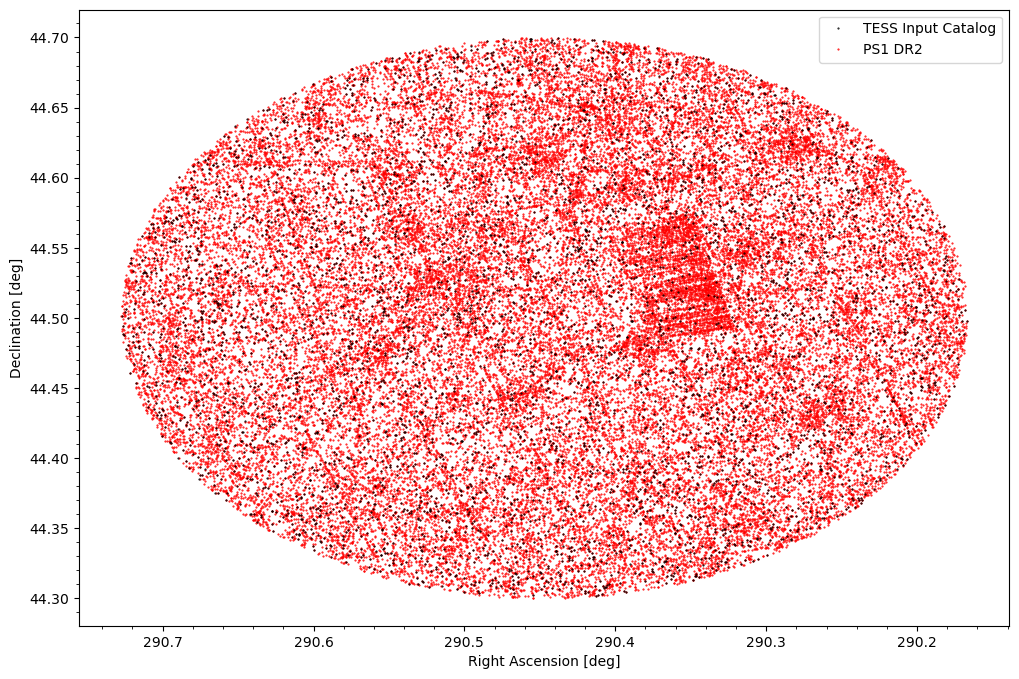

In [3]:
# Plot the stars within that region:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=1,label='TESS Input Catalog')
plt.plot(ps1_data['raMean'],ps1_data['decMean'],'r.',ms=1,label='PS1 DR2',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

In [4]:
# Notice how there are many more PS1 sources (red) than TIC sources (black). This is because the PS1 catalog goes deeper than the TIC, so it includes dimmer objects.
# Now that we have sources from both catalogs, we can do a simple crossmatch with their current positions:
from astroML.crossmatch import crossmatch_angular
dist, ind = crossmatch_angular(np.transpose([tic_data['ra'],tic_data['dec']]),np.transpose([ps1_data['raMean'],ps1_data['decMean']]),3./3600.)

In [5]:
# Define mask to ignore objects without matches and ones that go over the maximum array length (inf designation according to astroML package documentation):
mask_cross = np.where((dist < 1.) & (ind < 51032))[0]

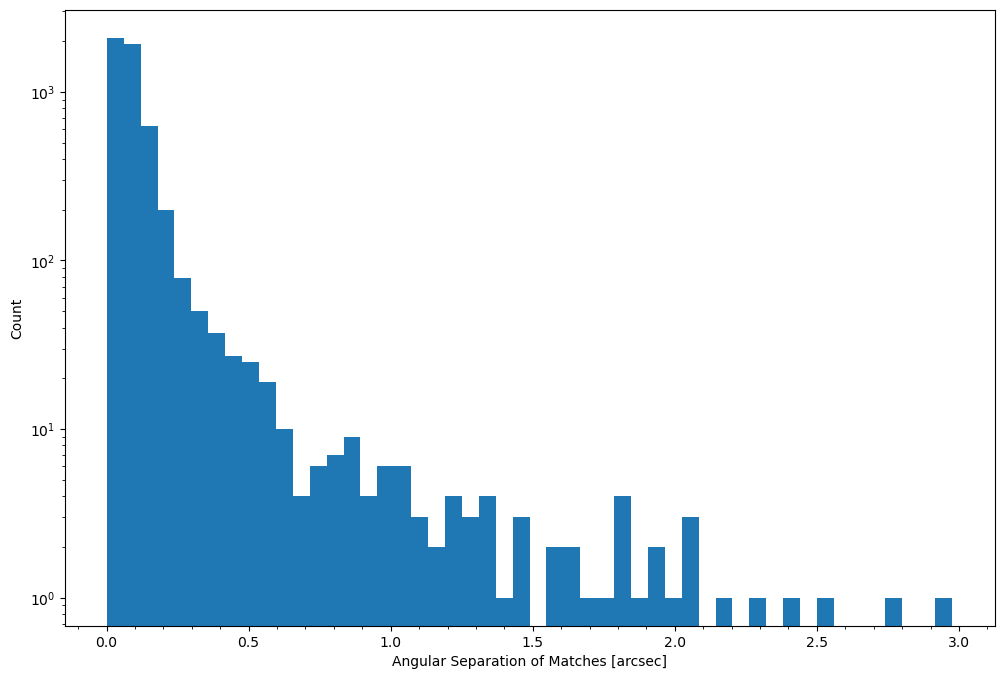

In [6]:
# Now we can plot the histogram of separations:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(dist[mask_cross]*3600.,bins=50)
plt.xlabel('Angular Separation of Matches [arcsec]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

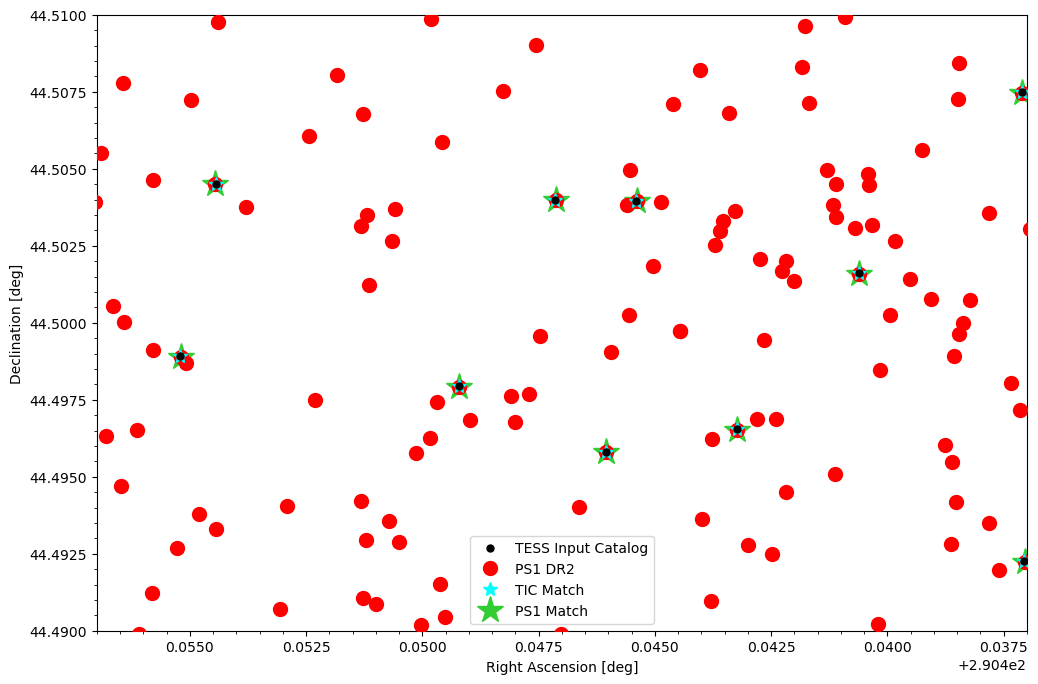

In [7]:
# Now let's zoom in on a particular region of the sky and see what's going on:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=10,label='TESS Input Catalog',zorder=5)
plt.plot(ps1_data['raMean'],ps1_data['decMean'],'r.',ms=20,label='PS1 DR2',zorder=3)
plt.plot(tic_data[mask_cross]['ra'],tic_data[mask_cross]['dec'],c='cyan',marker='*',ms=10,linestyle='',label='TIC Match',zorder=4)
plt.plot(ps1_data[ind[mask_cross]]['raMean'],ps1_data[ind[mask_cross]]['decMean'],c='limegreen',marker='*',ms=20,linestyle='',label='PS1 Match',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.xlim([290.437,290.457])
plt.ylim([44.49,44.51])
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

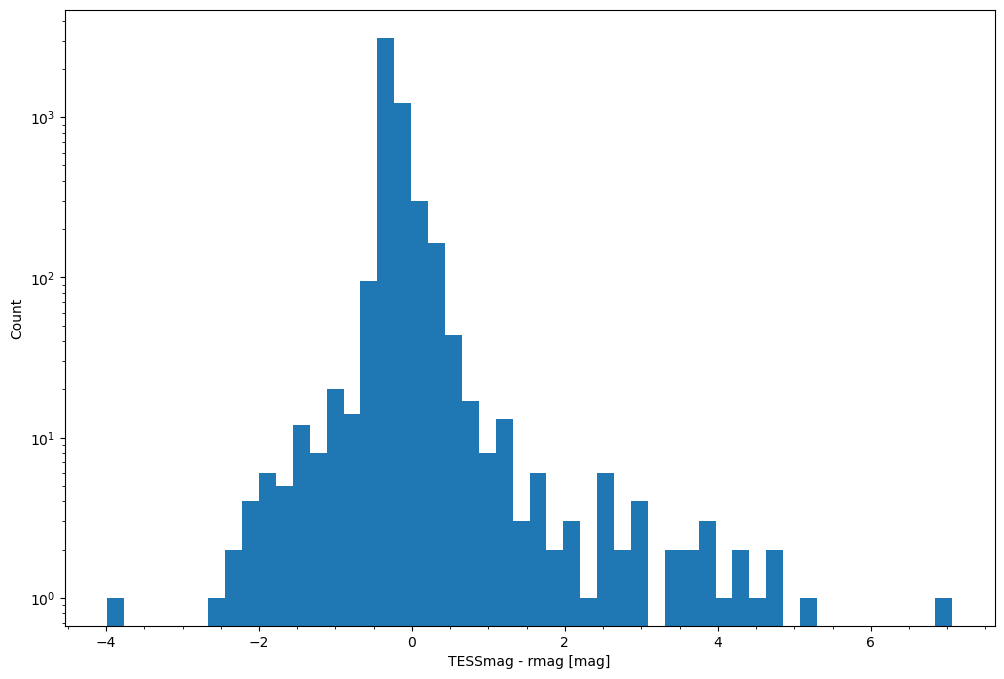

In [8]:
# Another thing we can do is compare magnitudes between stars in the TIC and those in PS1. Let's choose filters with similar wavelengths (TESSmag and imag):

# Plot the comparison:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(tic_data[mask_cross]['Tmag'] - ps1_data[ind[mask_cross]]['iMeanPSFMag'],bins=50)
plt.xlabel('TESSmag - rmag [mag]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

In [9]:
# You'll notice we get a nice gaussian distribution about roughly 0, but there is some scatter in the magnitudes, with a tail at TESSmag - rmag > 2.0. These are likely giant stars, where color relations are different for stars in different luminosity classes.
# The large outliers (~-4 and >6) could be instances where there are issues with the photometry in one or both catalogs or the indication of a false match.

In [10]:
# Now this is a bit of an oversimplification - namely, because stars are not stationary and are constantly moving relative to our perspective. A proper crossmatch would include not only positions, but proper motion considerations and time of observation.
# Fortunately, the TIC positions and PS1 positions were taken at a similar epoch, but in instances where years separate observations and stars have significant proper motions, a simple crossmatch like this would not be sufficient.
# You can already see how small movements of individual stars could result in completely different matches being chosen in a few cases, and this becomes an issue in particularly dense regions of the sky (think galactic plane/nucleus).

In [11]:
# Another thing we can do is a direct crossmatch with the Gaia catalog:
from astroquery.xmatch import XMatch # To crossmatch with Gaia DR3 data
from astropy import units as u # Define u for units

# Next, do a conesearch of the TIC to set up eventual crossmatching and plot the distribution of the stars:
tic_data = Catalogs.query_region("290.447 44.5",radius = 0.2,catalog='TIC')

matched_table = XMatch.query(cat1=tic_data,
                     cat2='vizier:I/355/gaiadr3',
                     max_distance=3 * u.arcsec, colRA1='ra',
                     colDec1='dec')

Could not import regions, which is required for some of the functionalities of this module.


In [12]:
matched_table

angDist,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,SolID,Source,RandomI,e_RAdeg,e_DEdeg,Plx,e_Plx,RPlx,PM,pmRA2,e_pmRA2,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NbAL,gofAL,chi2AL,epsi,sepsi,Solved,APF,nueff,pscol,e_pscol,RApscolCorr,DEpscolCorr,PlxpscolCorr,pmRApscolCorr,pmDEpscolCorr,MatchObsA,Nper,amax,MatchObs,IPDgofha,IPDgofhp,IPDfmp,IPDfow,RUWE,Dup,o_Gmag,FG,e_FG,RFG,Gmag,e_Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,e_BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,e_RPmag,E(BP/RP),NBPcont,NBPblend,NRPcont,NRPblend,Mode,BP-RP,BP-G,G-RP,RV,e_RV,n_RV,o_RV,o_RVd,RVNper,RVS/N,RVgof,RVchi2,RVTdur,RVamp,RVtempTeff,RVtemplogg,RVtemp[Fe/H],Vatmparam,vbroad,e_Vbroad,o_Vbroad,GRVSmag,e_GRVSmag,o_GRVSmag,RVSS/N,VarFlag,PQSO,PGal,PSS,Teff2,b_Teff,B_Teff,logg2,b_logg,B_logg,[Fe/H],b_[Fe/H],B_[Fe/H],Dist,b_Dist,B_Dist,A0,b_A0,B_A0,AG,b_AG,B_AG,E(BP-RP),b_E(BP-RP),B_E(BP-RP),Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000
arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,,,,mas,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,deg,,,,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,dex(cm / s2),dex,,km / s,km / s,,mag,mag,,,,,,,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,
float64,int64,float64,float64,float64,float64,float32,str8,str7,int32,bool,str12,str10,str16,bool,str19,int64,int32,int32,str8,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,str5,str5,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float32,float32,float64,float64,int16,float64,str9,int64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,str6,float32,float32,str5,float32,float64,float32,float64,int16,bool,str8,str8,str13,float64,float64,float64,float64,float64,float64,int16,int16,float64,str28,float64,float64,float32,float32,float32,int64,int64,int32,float32,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,uint8,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,uint8,float32,int16,float32,float32,uint8,uint8,float32,uint8,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,int16,int16,int16,int16,u

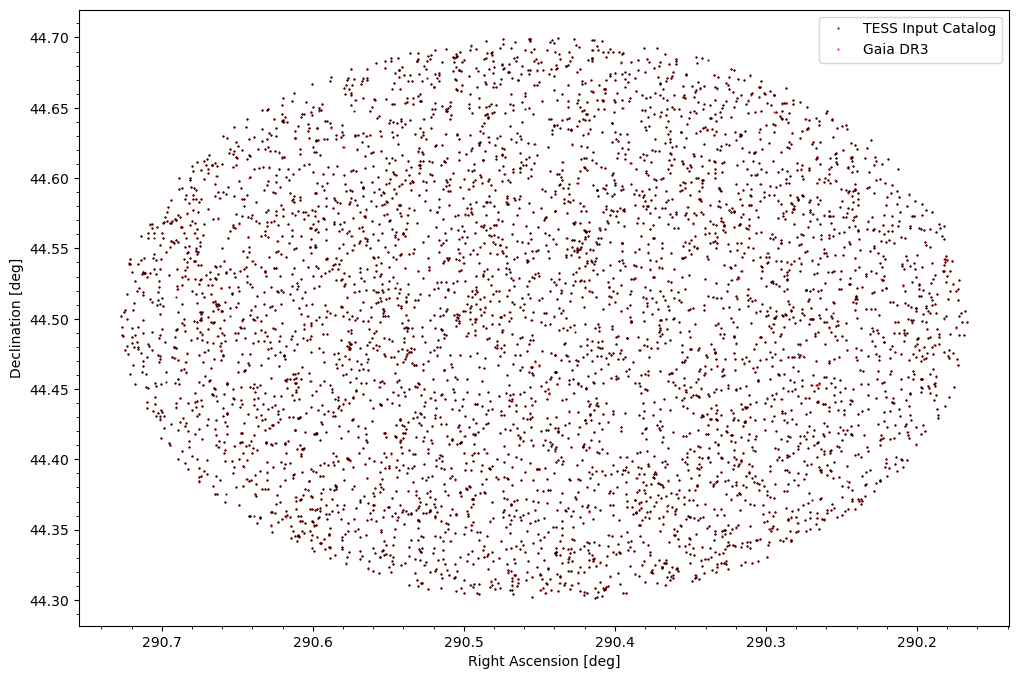

In [13]:
# Plot the stars within that region:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=1,label='TESS Input Catalog')
plt.plot(matched_table['RAdeg'],matched_table['DEdeg'],'r.',ms=1,label='Gaia DR3',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

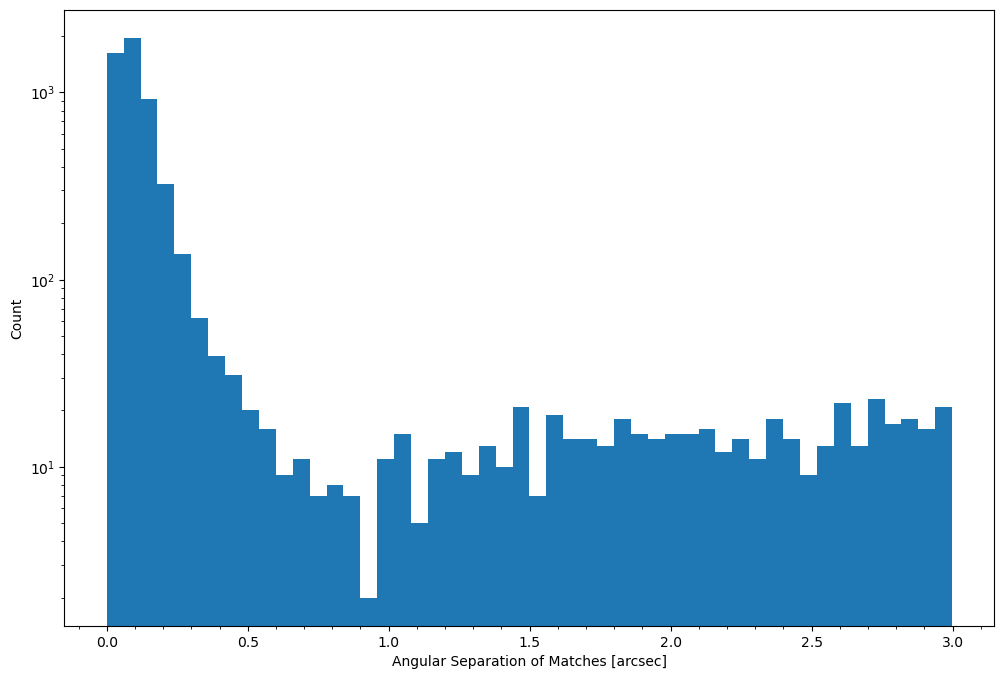

In [14]:
# Now we can plot the histogram of separations:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(matched_table['angDist'],bins=50)
plt.xlabel('Angular Separation of Matches [arcsec]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

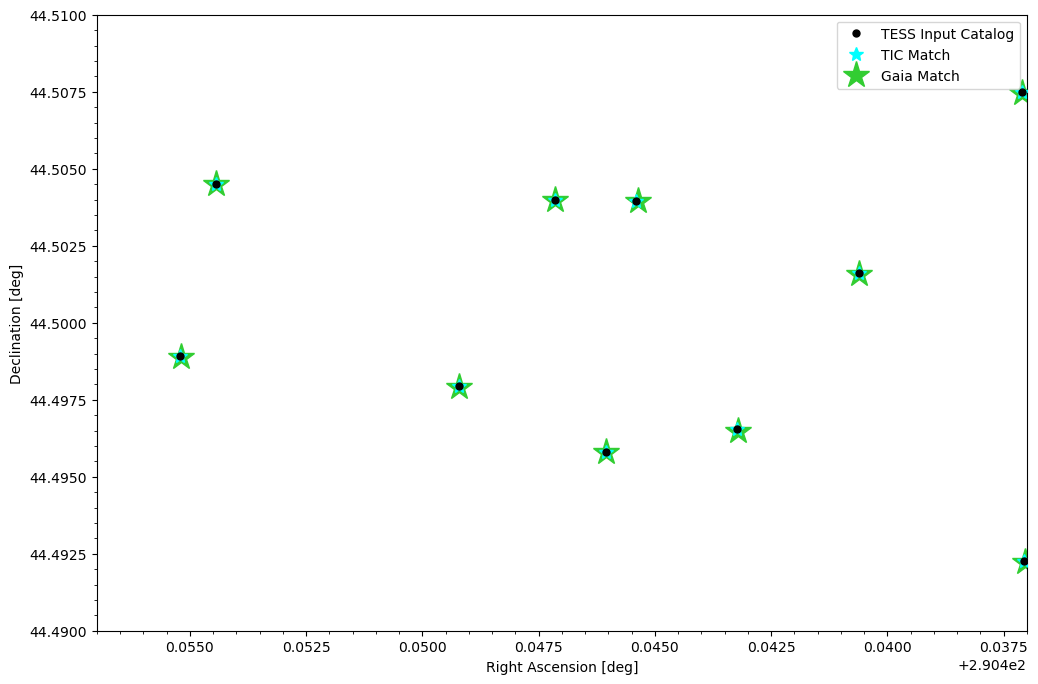

In [15]:
# Now let's zoom in on a particular region of the sky and see what's going on:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.plot(tic_data['ra'],tic_data['dec'],'k.',ms=10,label='TESS Input Catalog',zorder=5)
plt.plot(matched_table['ra'],matched_table['dec'],c='cyan',marker='*',ms=10,linestyle='',label='TIC Match',zorder=4)
plt.plot(matched_table['RAdeg'],matched_table['DEdeg'],c='limegreen',marker='*',ms=20,linestyle='',label='Gaia Match',zorder=1)
plt.legend(loc='best')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.xlim([290.437,290.457])
plt.ylim([44.49,44.51])
plt.minorticks_on()
plt.gca().invert_xaxis()
plt.show()

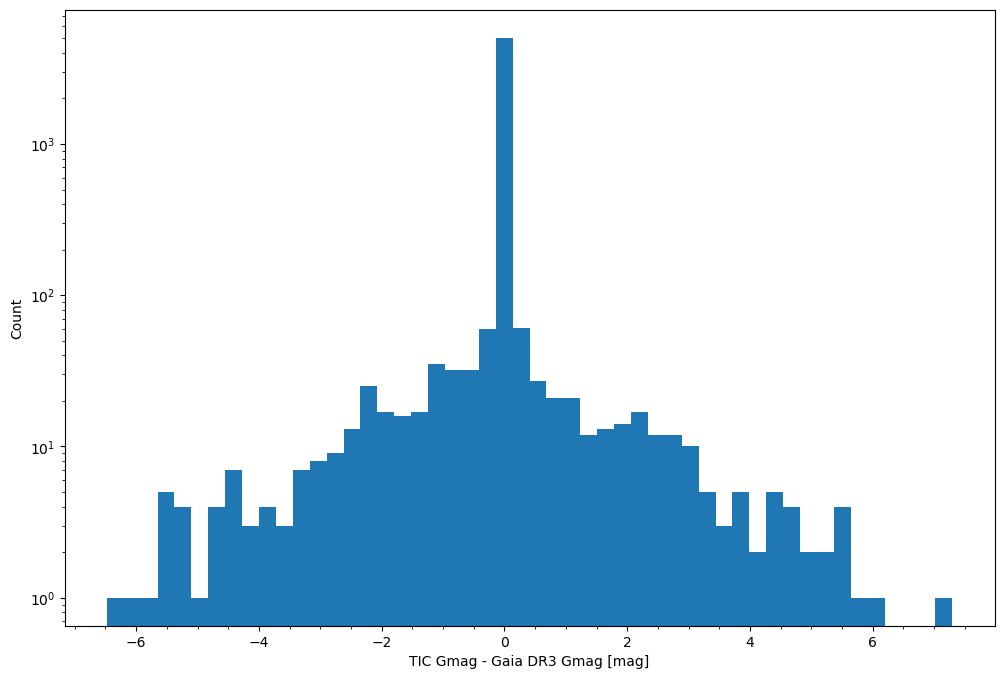

In [17]:
# Plot the comparison:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plt.hist(matched_table['GAIAmag'] - matched_table['Gmag'],bins=50)
plt.xlabel('TIC Gmag - Gaia DR3 Gmag [mag]')
plt.ylabel('Count')
plt.yscale('log')
plt.minorticks_on()
plt.show()

In [30]:
source_id_diff = matched_table['Source'] - matched_table['GAIA']
print('Number of different DR2 vs. DR3 source ids, total matched:',len(np.nonzero(source_id_diff)[0]),len(matched_table))
gmag_diff = matched_table['GAIAmag'] - matched_table['Gmag']
print('Number of Gmags differing by > 0.1 mag, total:',len(np.where(np.abs(gmag_diff) > 0.1)[0]),len(matched_table))

Number of different DR2 vs. DR3 source ids, total matched: 701 5669
Number of Gmags differing by > 0.1 mag, total: 712 5669
